In [ ]:
"""
Implementation of ProGAN generator and discriminator with the key
attributions from the paper. We have tried to make the implementation
compact but a goal is also to keep it readable and understandable.
Specifically the key points implemented are:

1) Progressive growing (of model and layers)
2) Minibatch std on Discriminator
3) Normalization with PixelNorm
4) Equalized Learning Rate (here I cheated and only did it on Conv layers)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2

"""
Factors is used in Discrmininator and Generator for how much
the channels should be multiplied and expanded for each layer,
so specifically the first 5 layers the channels stay the same,
whereas when we increase the img_size (towards the later layers)
we decrease the number of chanels by 1/2, 1/4, etc.
"""
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]


class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.

    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)


class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

'''
if __name__ == "__main__":
    Z_DIM = 100
    IN_CHANNELS = 256
    gen = Generator(Z_DIM, IN_CHANNELS, img_channels=3)
    critic = Discriminator(Z_DIM, IN_CHANNELS, img_channels=3)

    for img_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
        num_steps = int(log2(img_size / 4))
        x = torch.randn((1, Z_DIM, 1, 1))
        z = gen(x, 0.5, steps=num_steps)
        assert z.shape == (1, 3, img_size, img_size)
        out = critic(z, alpha=0.5, steps=num_steps)
        assert out.shape == (1, 1)
        print(f"Success! At img size: {img_size}")
        '''

'\nif __name__ == "__main__":\n    Z_DIM = 100\n    IN_CHANNELS = 256\n    gen = Generator(Z_DIM, IN_CHANNELS, img_channels=3)\n    critic = Discriminator(Z_DIM, IN_CHANNELS, img_channels=3)\n\n    for img_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:\n        num_steps = int(log2(img_size / 4))\n        x = torch.randn((1, Z_DIM, 1, 1))\n        z = gen(x, 0.5, steps=num_steps)\n        assert z.shape == (1, 3, img_size, img_size)\n        out = critic(z, alpha=0.5, steps=num_steps)\n        assert out.shape == (1, 1)\n        print(f"Success! At img size: {img_size}")\n        '

In [ ]:
import cv2
import torch
from math import log2

START_TRAIN_AT_IMG_SIZE = 128
DATASET = 'celeb_dataset'
CHECKPOINT_GEN = "generator (1).pth"
CHECKPOINT_CRITIC = "critic (1).pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_MODEL = True
LOAD_MODEL = True
LEARNING_RATE = 1e-3
BATCH_SIZES = [32, 32, 32, 16, 16, 16, 16, 8, 4]
CHANNELS_IMG = 3
Z_DIM = 256  # should be 512 in original paper
IN_CHANNELS = 256  # should be 512 in original paper
CRITIC_ITERATIONS = 1
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [50] * len(BATCH_SIZES)
FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(DEVICE)
NUM_WORKERS = 4

In [ ]:
import torch
import random
import numpy as np
import os
import torchvision
import torch.nn as nn
#import config
from torchvision.utils import save_image
from scipy.stats import truncnorm

# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)


def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cpu")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

import matplotlib.pyplot as plt
def generate_examples(gen, steps, truncation=0.7, n=10):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    alpha = 1.0
    cols = 5  # Number of columns in the grid
    rows = 2  # Number of rows in the grid

    fig, axes = plt.subplots(rows, cols, figsize=(6, 3))  # Adjust figsize as needed
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, Z_DIM, 1, 1)), device=DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            img = img * 0.5 + 0.5

            # Select the first image from the batch
            tensor = img[0]  # Assuming img has shape (batch_size, channels, height, width)

            # Show the image on the corresponding subplot
            axes[i].imshow(tensor.permute(1, 2, 0).cpu().numpy())
            axes[i].axis('off')  # Turn off the axis

    # Hide any unused subplots
    for j in range(n, rows * cols):
        axes[j].axis('off')

    plt.tight_layout()  # Adjust the layout
    plt.show()
    gen.train()

In [ ]:
""" Training of ProGAN using WGAN-GP loss"""
import time
import torch
from PIL import Image
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
'''from utils import (
    gradient_penalty,
    plot_to_tensorboard,
    save_checkpoint,
    load_checkpoint,
    generate_examples,
)
from model import Discriminator, Generator'''
from math import log2
from tqdm import tqdm
#import config

torch.backends.cudnn.benchmarks = True
from PIL import UnidentifiedImageError

class ImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        img_dir: Directory where all images are stored.
        transform: Optional transforms to apply to the images (e.g., Resize, Normalize).
        """
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]  # Add more extensions if necessary

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])

        try:
            start_time = time.time()
            image = Image.open(img_path).convert('RGB')

            # Set a timeout for data loading
            if time.time() - start_time > 5:  # 5 seconds threshold
                raise TimeoutError(f"Skipping {img_path} due to timeout.")

            if self.transform:
                image = self.transform(image)

            return image
        except  IOError as e:
            print(f"Skipping {img_path} due to error: {e}")
            return None

        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return None  # Skip this data point

def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = ImageDataset(img_dir="/content/drive/MyDrive/images", transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
        prefetch_factor=2,
    )
    return loader, dataset


def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, real in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size,Z_DIM, 1, 1).to(DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen(FIXED_NOISE, alpha, step) * 0.5 + 0.5
            plot_to_tensorboard(
                writer,
                loss_critic.item(),
                loss_gen.item(),
                real.detach(),
                fixed_fakes.detach(),
                tensorboard_step,
            )
            tensorboard_step += 1

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )

    return tensorboard_step, alpha


def main():
    # initialize gen and disc, note: discriminator should be called critic,
    # according to WGAN paper (since it no longer outputs between [0, 1])
    # but really who cares..
    gen = Generator(
        Z_DIM,IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)
    critic = Discriminator(
        Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)

    # initialize optimizers and scalers for FP16 training
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
    opt_critic = optim.Adam(
        critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
    )
    scaler_critic = torch.cuda.amp.GradScaler()
    scaler_gen = torch.cuda.amp.GradScaler()

    # for tensorboard plotting
    writer = SummaryWriter(f"logs/gan1")

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC, critic, opt_critic, LEARNING_RATE,
        )

    gen.train()
    critic.train()

    tensorboard_step = 0
    # start at step that corresponds to img size that we set in config
    step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
    for num_epochs in PROGRESSIVE_EPOCHS[step:]:
        alpha = 1e-5  # start with very low alpha
        loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            tensorboard_step, alpha = train_fn(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen,
                tensorboard_step,
                writer,
                scaler_gen,
                scaler_critic,
            )
            generate_examples(gen, step, truncation=0.7, n=100)

            if SAVE_MODEL:
                save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
                save_checkpoint(critic, opt_critic, filename=CHECKPOINT_CRITIC)

        step += 1  # progress to the next img size


if __name__ == "__main__":
    main()

<ipython-input-4-6f5fb1d0de1f>:178: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_critic = torch.cuda.amp.GradScaler()
<ipython-input-4-6f5fb1d0de1f>:179: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_gen = torch.cuda.amp.GradScaler()
<ipython-input-3-c2d503e7e890>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be l

=> Loading checkpoint


RuntimeError: PytorchStreamReader failed reading zip archive: failed finding central directory

=> Loading checkpoint
=> Loading checkpoint


<ipython-input-2-c2d503e7e890>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_file, map_location="cpu")


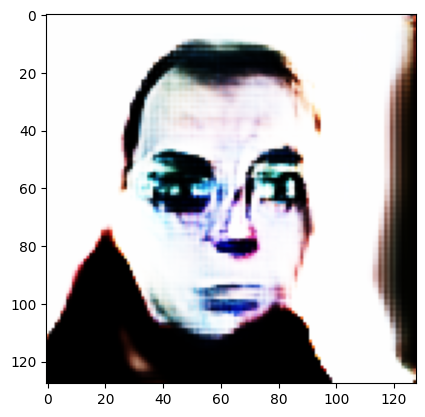

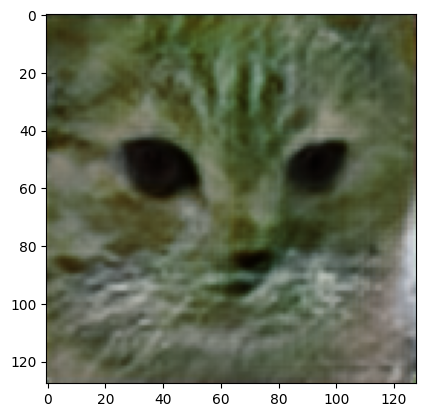

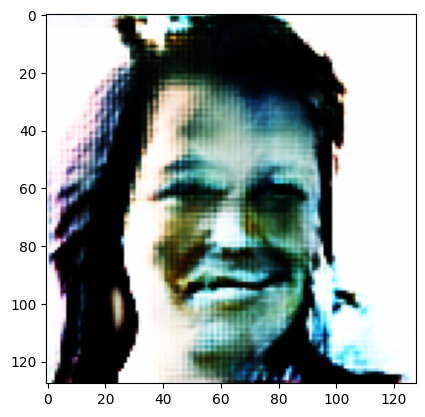

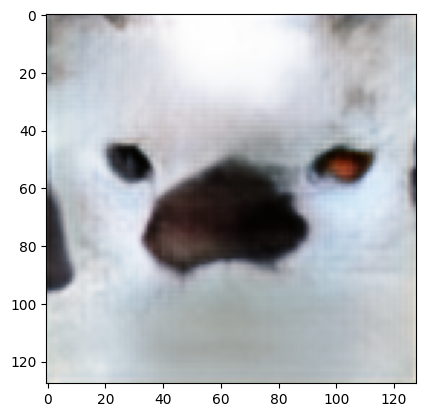

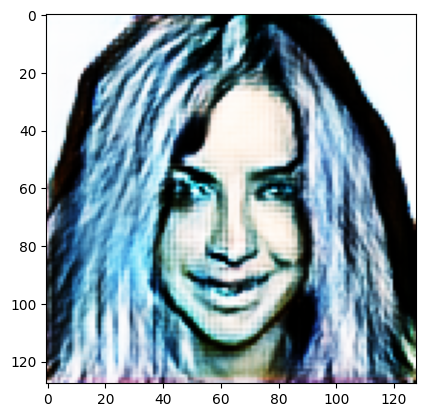

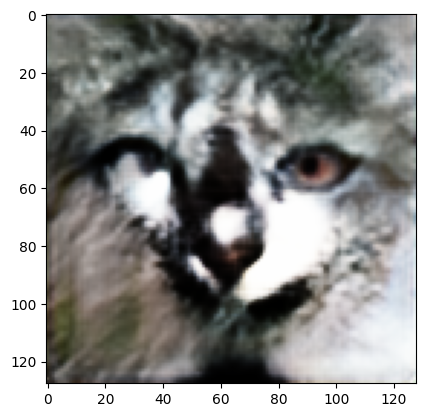

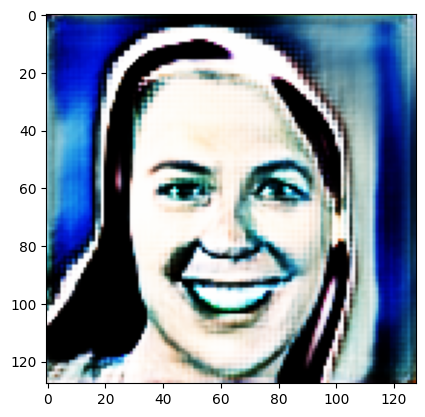

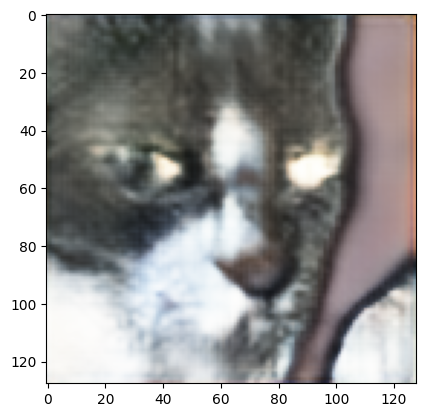

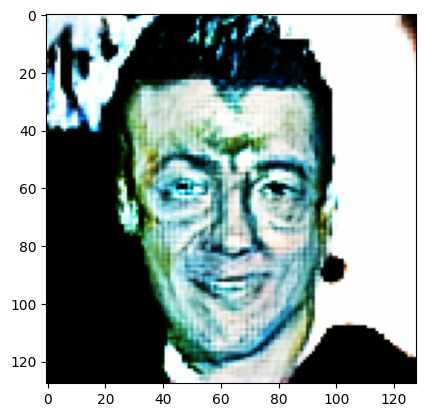

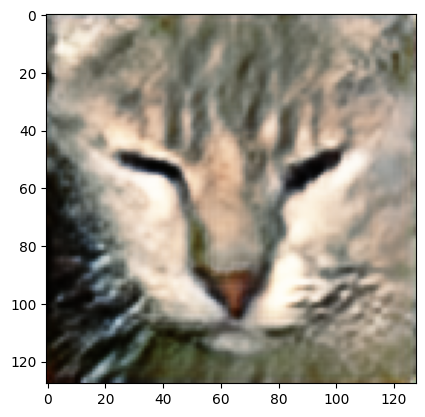

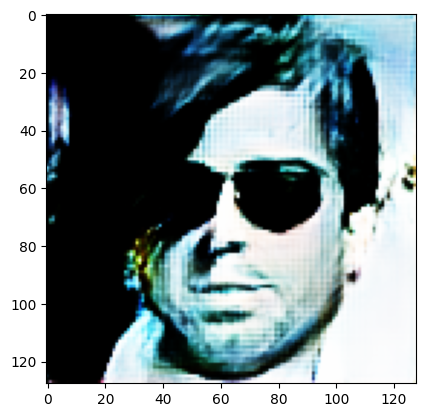

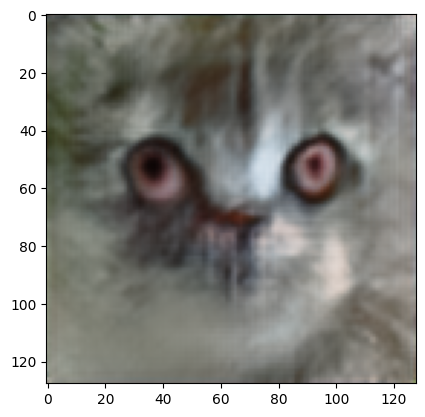

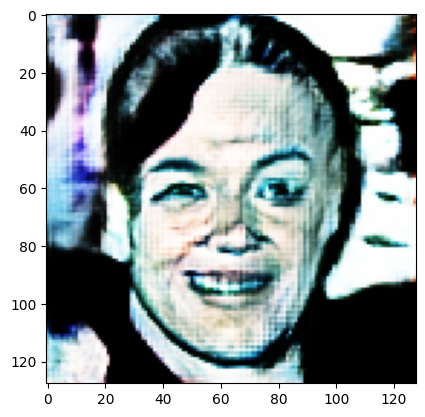

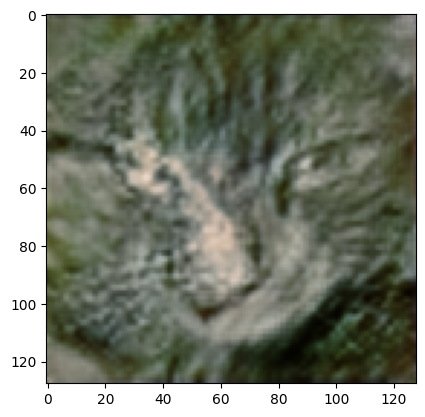

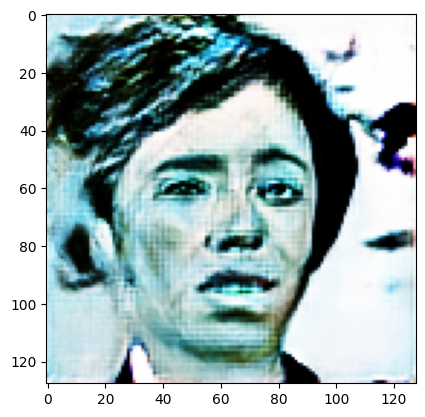

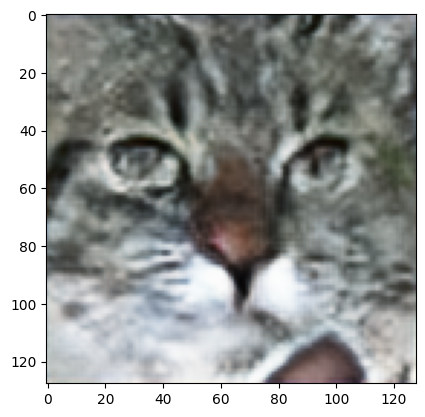

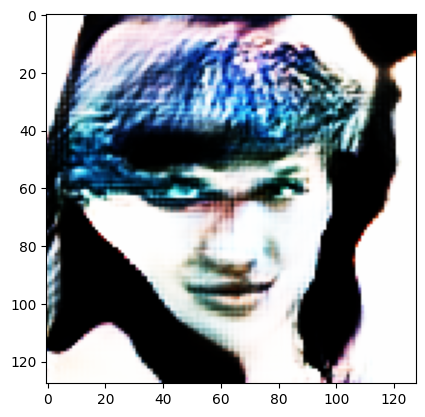

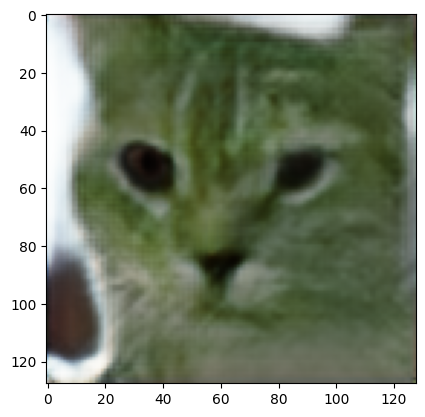

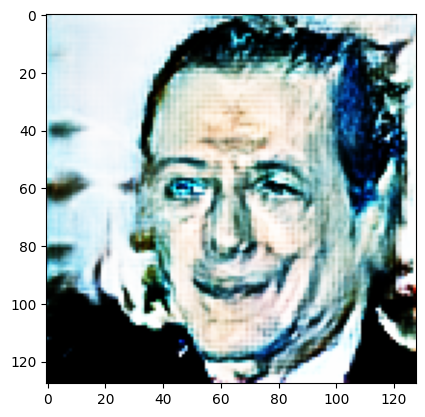

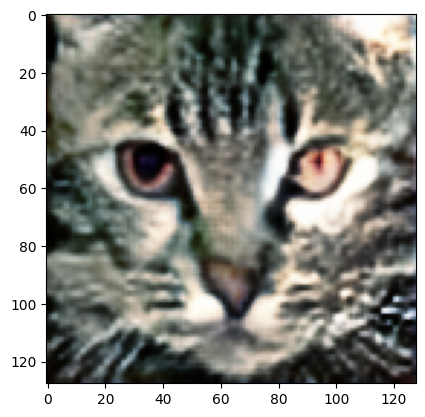

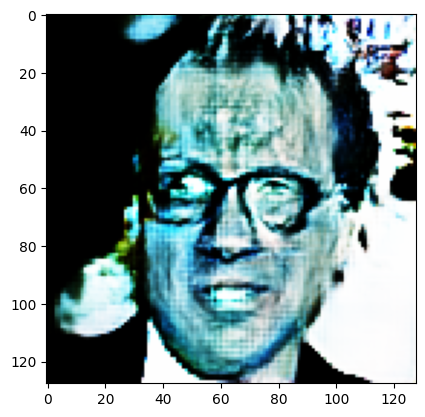

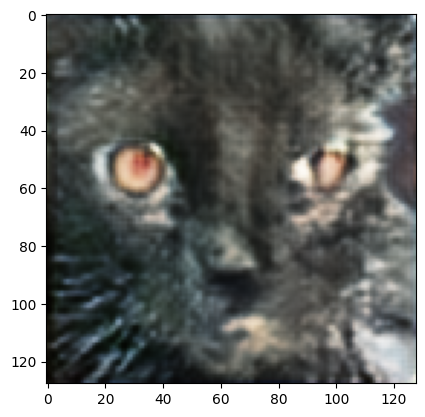

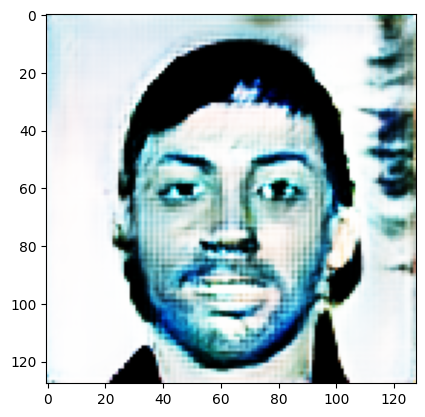

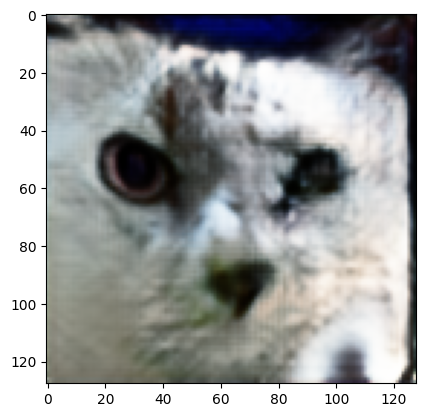

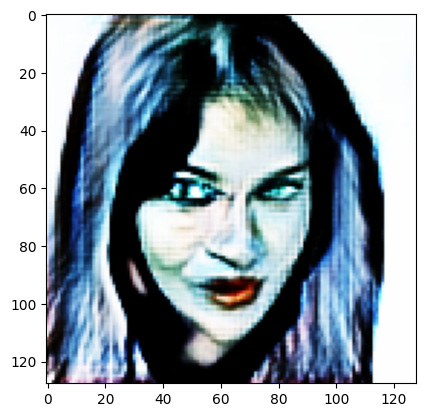

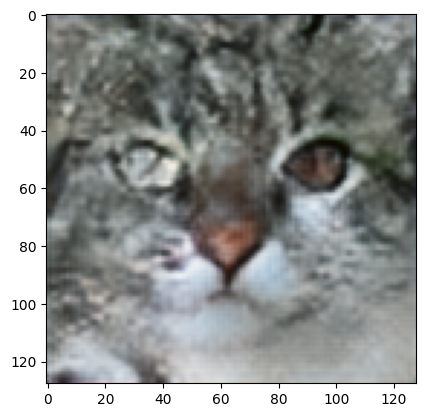

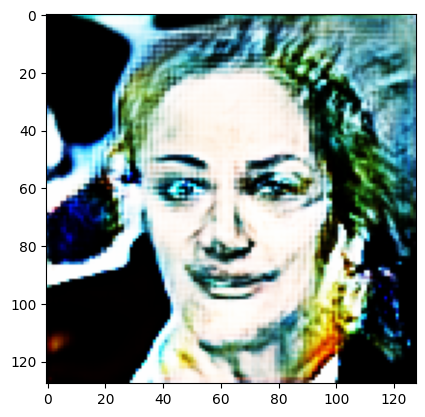

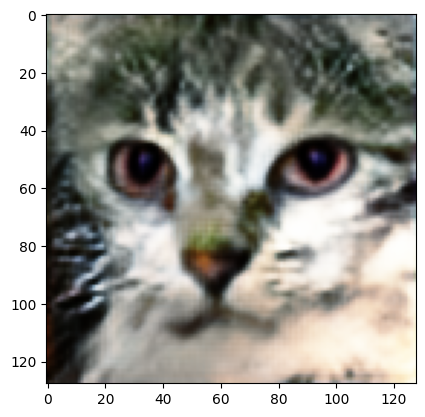

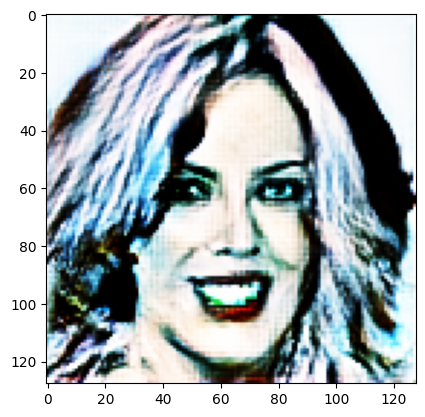

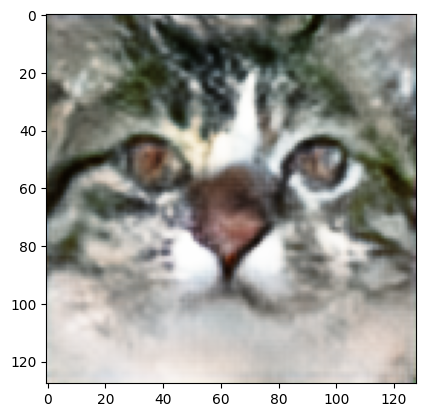

In [ ]:
import time
import torch
from PIL import Image
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
gen1 = Generator(
        Z_DIM,IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)
gen2=Generator(
        Z_DIM,IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)

opt_gen1 = optim.Adam(gen1.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_gen2 = optim.Adam(gen2.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))

if LOAD_MODEL:
        load_checkpoint(
            "generator.pth", gen1, opt_gen1, LEARNING_RATE,
        )
        load_checkpoint(
            "generator (1).pth", gen2, opt_gen2, LEARNING_RATE,
        )

alpha = 1.0
step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
for i in range(15):
  with torch.no_grad():
    truncation=0.7
    noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, Z_DIM, 1, 1)), device=DEVICE, dtype=torch.float32)
    #print(noise)
    img1 = gen1(noise, alpha, step)
    img1 = img1 * 0.5 + 0.5
    plt.imshow(img1[0].permute(1, 2, 0).cpu().numpy())
    plt.show()
    img2=gen2(noise, alpha, step)
    img2 = img2 * 0.5 + 0.5
    plt.imshow(img2[0].permute(1, 2, 0).cpu().numpy())
    plt.show()


#### Generated model

In [ ]:
noise1=torch.tensor([[[[-0.6662]],

         [[ 0.1419]],

         [[ 0.4422]],

         [[ 0.4421]],

         [[ 0.3784]],

         [[ 0.6123]],

         [[-0.6596]],

         [[-0.2700]],

         [[-0.5257]],

         [[ 0.2962]],

         [[-0.6457]],

         [[-0.0238]],

         [[ 0.0070]],

         [[-0.4138]],

         [[ 0.3038]],

         [[ 0.1257]],

         [[-0.6912]],

         [[-0.2838]],

         [[ 0.6784]],

         [[-0.4188]],

         [[ 0.4316]],

         [[-0.1633]],

         [[-0.1965]],

         [[-0.3687]],

         [[ 0.3110]],

         [[-0.4977]],

         [[-0.4780]],

         [[ 0.5143]],

         [[-0.0604]],

         [[-0.0322]],

         [[-0.3541]],

         [[-0.2020]],

         [[-0.2418]],

         [[-0.1078]],

         [[ 0.4075]],

         [[ 0.4560]],

         [[-0.1058]],

         [[-0.1447]],

         [[ 0.3145]],

         [[-0.2525]],

         [[ 0.1291]],

         [[-0.2698]],

         [[ 0.6131]],

         [[-0.4942]],

         [[-0.1459]],

         [[ 0.3884]],

         [[-0.0811]],

         [[ 0.5954]],

         [[-0.6109]],

         [[-0.1918]],

         [[-0.1217]],

         [[ 0.6893]],

         [[ 0.6635]],

         [[ 0.6819]],

         [[-0.0732]],

         [[-0.4358]],

         [[ 0.3019]],

         [[ 0.0853]],

         [[-0.2194]],

         [[ 0.3446]],

         [[-0.0504]],

         [[ 0.1671]],

         [[ 0.6076]],

         [[ 0.1503]],

         [[-0.5739]],

         [[-0.6269]],

         [[-0.5163]],

         [[-0.0344]],

         [[ 0.2067]],

         [[ 0.4584]],

         [[-0.3471]],

         [[-0.5162]],

         [[ 0.6602]],

         [[ 0.4497]],

         [[ 0.3223]],

         [[-0.0281]],

         [[-0.4189]],

         [[ 0.5398]],

         [[ 0.0180]],

         [[-0.4736]],

         [[-0.4552]],

         [[ 0.2799]],

         [[ 0.4757]],

         [[ 0.4546]],

         [[ 0.1286]],

         [[ 0.2631]],

         [[-0.6131]],

         [[ 0.2654]],

         [[ 0.4669]],

         [[ 0.3515]],

         [[-0.2747]],

         [[ 0.6520]],

         [[ 0.5695]],

         [[-0.2523]],

         [[-0.1276]],

         [[ 0.2614]],

         [[-0.5747]],

         [[ 0.6678]],

         [[ 0.0484]],

         [[ 0.2105]],

         [[-0.2426]],

         [[-0.3216]],

         [[ 0.5368]],

         [[-0.6423]],

         [[-0.6982]],

         [[-0.3782]],

         [[-0.6571]],

         [[-0.0444]],

         [[ 0.2991]],

         [[ 0.1527]],

         [[-0.3295]],

         [[ 0.1754]],

         [[ 0.4910]],

         [[-0.2356]],

         [[ 0.0406]],

         [[-0.5947]],

         [[-0.2177]],

         [[-0.1129]],

         [[-0.3056]],

         [[ 0.1503]],

         [[-0.6793]],

         [[-0.3304]],

         [[ 0.2534]],

         [[ 0.5631]],

         [[ 0.0287]],

         [[ 0.2418]],

         [[ 0.0689]],

         [[-0.0085]],

         [[-0.0728]],

         [[ 0.4544]],

         [[-0.5599]],

         [[ 0.0700]],

         [[ 0.6298]],

         [[-0.6616]],

         [[-0.0318]],

         [[-0.3201]],

         [[-0.3295]],

         [[ 0.3230]],

         [[ 0.0169]],

         [[-0.4222]],

         [[-0.4275]],

         [[ 0.0472]],

         [[ 0.6073]],

         [[-0.0871]],

         [[-0.6583]],

         [[ 0.3071]],

         [[ 0.1182]],

         [[-0.2952]],

         [[ 0.6002]],

         [[-0.5718]],

         [[-0.6924]],

         [[ 0.4589]],

         [[ 0.1085]],

         [[-0.4137]],

         [[-0.4236]],

         [[ 0.1884]],

         [[-0.4135]],

         [[ 0.2999]],

         [[-0.5211]],

         [[ 0.4900]],

         [[-0.5452]],

         [[ 0.0536]],

         [[-0.6907]],

         [[-0.3318]],

         [[-0.3394]],

         [[ 0.4707]],

         [[ 0.6637]],

         [[-0.6078]],

         [[-0.0109]],

         [[ 0.1448]],

         [[ 0.0567]],

         [[ 0.6386]],

         [[ 0.6602]],

         [[ 0.6527]],

         [[-0.1057]],

         [[ 0.6678]],

         [[-0.5003]],

         [[-0.2151]],

         [[-0.2941]],

         [[-0.2022]],

         [[ 0.5202]],

         [[ 0.4110]],

         [[ 0.3482]],

         [[-0.2514]],

         [[-0.0224]],

         [[-0.2132]],

         [[-0.2429]],

         [[ 0.2418]],

         [[ 0.2050]],

         [[ 0.4419]],

         [[ 0.2079]],

         [[ 0.6542]],

         [[ 0.0966]],

         [[-0.6533]],

         [[-0.5627]],

         [[ 0.0311]],

         [[-0.0801]],

         [[-0.0113]],

         [[ 0.3589]],

         [[ 0.4591]],

         [[ 0.5799]],

         [[ 0.1870]],

         [[ 0.1309]],

         [[-0.1360]],

         [[ 0.0683]],

         [[-0.0530]],

         [[ 0.3656]],

         [[-0.6262]],

         [[-0.6288]],

         [[ 0.4851]],

         [[ 0.0606]],

         [[ 0.2961]],

         [[-0.5344]],

         [[ 0.0571]],

         [[-0.4747]],

         [[ 0.2577]],

         [[ 0.4016]],

         [[ 0.2767]],

         [[-0.0984]],

         [[-0.5173]],

         [[-0.1053]],

         [[ 0.2970]],

         [[ 0.5692]],

         [[-0.2219]],

         [[ 0.3647]],

         [[ 0.3003]],

         [[ 0.3529]],

         [[ 0.0816]],

         [[ 0.2438]],

         [[ 0.2605]],

         [[-0.4094]],

         [[ 0.6980]],

         [[-0.0068]],

         [[-0.0240]],

         [[ 0.2290]],

         [[ 0.4831]],

         [[-0.4539]],

         [[-0.1232]],

         [[ 0.0520]],

         [[ 0.4074]],

         [[-0.6781]],

         [[-0.1782]],

         [[-0.1173]],

         [[ 0.4426]],

         [[ 0.5979]],

         [[-0.3165]],

         [[-0.0717]],

         [[-0.4301]],

         [[ 0.6787]],

         [[ 0.3725]],

         [[ 0.5520]],

         [[ 0.3615]],

         [[-0.0156]],

         [[-0.6544]],

         [[-0.6400]],

         [[ 0.1453]]]])
print(noise1)

tensor([[[[-0.6662]],

         [[ 0.1419]],

         [[ 0.4422]],

         [[ 0.4421]],

         [[ 0.3784]],

         [[ 0.6123]],

         [[-0.6596]],

         [[-0.2700]],

         [[-0.5257]],

         [[ 0.2962]],

         [[-0.6457]],

         [[-0.0238]],

         [[ 0.0070]],

         [[-0.4138]],

         [[ 0.3038]],

         [[ 0.1257]],

         [[-0.6912]],

         [[-0.2838]],

         [[ 0.6784]],

         [[-0.4188]],

         [[ 0.4316]],

         [[-0.1633]],

         [[-0.1965]],

         [[-0.3687]],

         [[ 0.3110]],

         [[-0.4977]],

         [[-0.4780]],

         [[ 0.5143]],

         [[-0.0604]],

         [[-0.0322]],

         [[-0.3541]],

         [[-0.2020]],

         [[-0.2418]],

         [[-0.1078]],

         [[ 0.4075]],

         [[ 0.4560]],

         [[-0.1058]],

         [[-0.1447]],

         [[ 0.3145]],

         [[-0.2525]],

         [[ 0.1291]],

         [[-0.2698]],

         [[ 0.6131]],

         [[

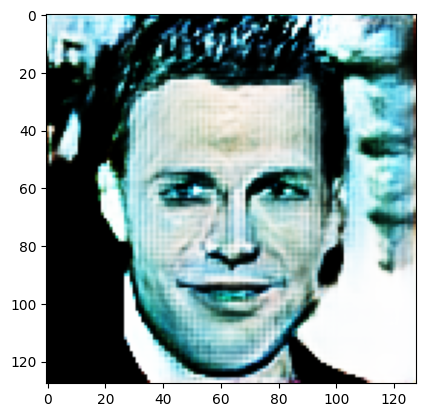

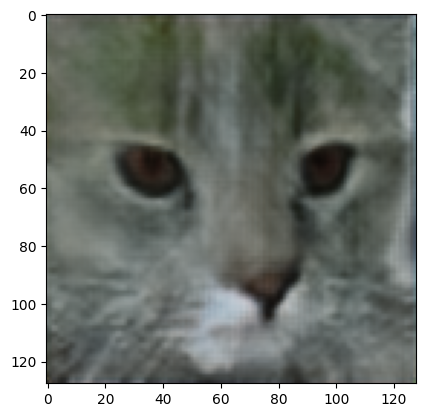

In [ ]:
img = gen1(noise1, alpha, step)
img = img * 0.5 + 0.5
plt.imshow(img[0].permute(1, 2, 0).cpu().detach().numpy())
plt.show()
img = gen2(noise1, alpha, step)
img = img * 0.5 + 0.5
plt.imshow(img[0].permute(1, 2, 0).cpu().detach().numpy())
plt.show()

0
success in lactation


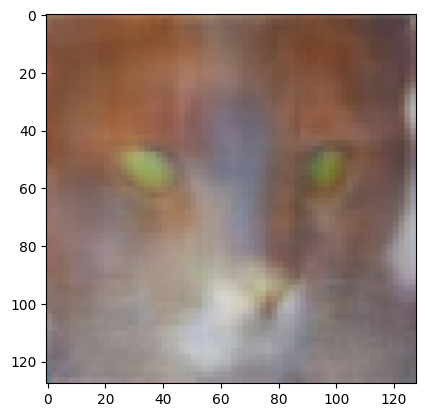

0.2
success in lactation


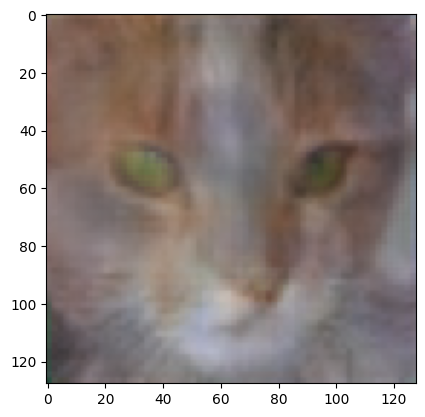

0.4
success in lactation


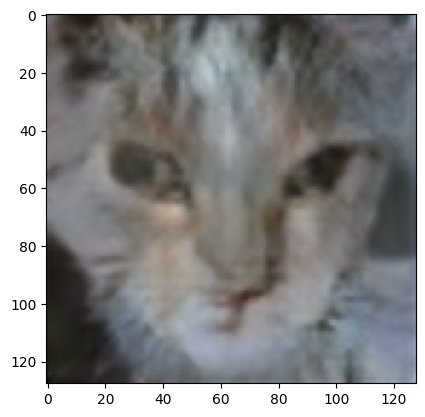

0.5
success in lactation


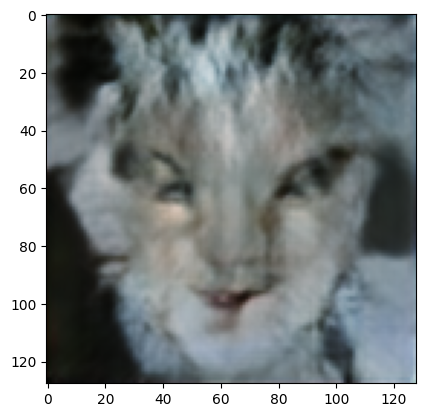

0.6
success in lactation


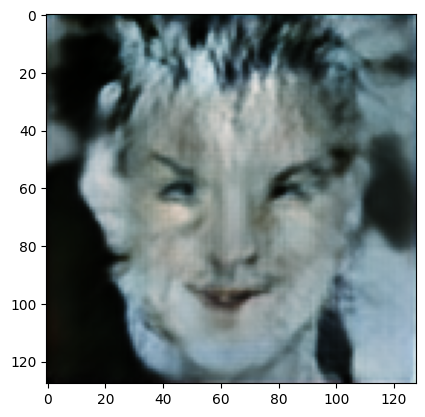

0.8
success in lactation


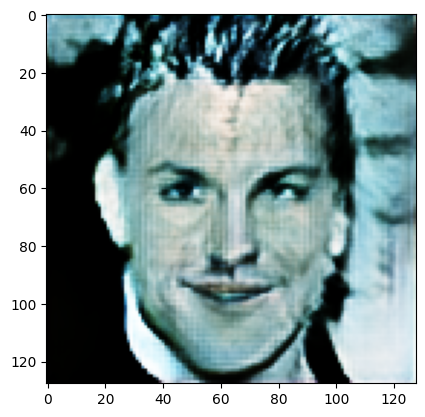

1
success in lactation


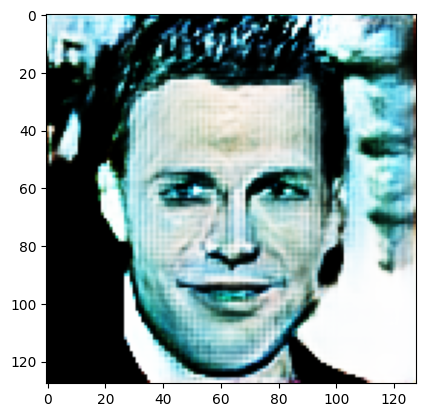

In [ ]:
import torch
import copy
import random
# Assume gen1 and gen2 are your two generators
# Create a copy of the generator for the EMA model

for alpha in [0, 0.2, 0.4 ,0.5, 0.6,  0.8, 1]:
# Set the smoothing factor (0 < alpha < 1)
  # Usually, alpha is close to 1 for slow updates
  ema_gen = copy.deepcopy(gen1)

# Function to perform EMA on the generator weights
  print(alpha)
  def update_ema(ema_gen, new_gen, alpha):
      for ema_param, new_param in zip(ema_gen.parameters(), new_gen.parameters()):
          ema_param.data = alpha * ema_param.data + (1 - alpha) * new_param.data
      print("success in lactation")

  # Assuming you want to compute EMA between two generators gen1 and gen2
  update_ema(ema_gen, gen2, alpha)

  img = ema_gen(noise1, alpha, step)
  img = img * 0.5 + 0.5
  plt.imshow(img[0].permute(1, 2, 0).cpu().detach().numpy())
  plt.show()